In [1]:
import Pkg
Pkg.activate("..")

  Activating project at `~/ascr_ad/AutoDiffSVDCompression`


In [2]:
Pkg.status()

Status `~/ascr_ad/AutoDiffSVDCompression/Project.toml`
  [13e28ba4] AppleAccelerate v0.4.1
  [c7e460c6] ArgParse v1.2.0
  [2685da08] BurgersEquation v0.1.0 `BurgersEquation`
  [336ed68f] CSV v0.10.15
  [d360d2e6] ChainRulesCore v1.25.1
  [523fee87] CodecBzip2 v0.8.5
  [5ba52731] CodecLz4 v0.4.6
  [ba30903b] CodecXz v0.7.4
  [944b1d66] CodecZlib v0.7.8
  [6b39b394] CodecZstd v0.8.6
  [a93c6f00] DataFrames v1.7.0
  [7a1cc6ca] FFTW v1.9.0
⌅ [f6369f11] ForwardDiff v0.10.38
  [e7cbb90b] ImplicitAD v0.3.1 `ImplicitAD`
  [d3d80556] LineSearches v7.3.0
  [429524aa] Optim v1.12.0
  [91a5bcdd] Plots v1.40.13
  [92933f4c] ProgressMeter v1.10.4
  [37e2e3b7] ReverseDiff v1.16.1
  [bd369af6] Tables v1.12.1
  [3bb67fe8] TranscodingStreams v0.11.3
  [29a6e085] Wavelets v0.10.1
Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated`


In [3]:
import CSV
import DataFrames

In [4]:
using Plots
using Statistics

# Computational Test Results

In [5]:
function make_base_name(ad, nx)
    return "large_scale_burger_solution_$(ad)_n$(nx)"
end

function make_file_name(ad, nx)
    return make_base_name(ad, nx) * ".txt"
end

function parse_results_file(fname::AbstractString)

    mrstr = read(fname, String)

    memreg = r"Max. RSS: *([0-9]+\.[0-9]*) MiB"
    m = match(memreg, mrstr)
    mem_use = -1.0
    if m !== nothing
        mem_use = parse(Float64, m[1])
    end

    treg = r"Seconds: *([0-9]+\.[0-9]*)"
    m = match(treg, mrstr)
    time = -1.0
    if m !== nothing
        time = parse(Float64, m[1])
    end

    ncreg = r"Number of Calls: *([0-9]+)"
    m = match(ncreg, mrstr)
    ncalls = 0
    if m !== nothing
        ncalls = parse(Int, m[1])
    end

    creg = r"Converged: *([a-z]+)"
    m = match(creg, mrstr)
    converged = false
    if m !== nothing
        converged = parse(Bool, m[1])
    end

    # greg = r"Gradient Residual: (/[+\-]?(?:0|[1-9]\d*)(?:\.\d+)?(?:[eE][+\-]?\d+)?/)"
    greg = r"Gradient Residual: ([0-9\.+\-eE]+)"
    m = match(greg, mrstr)
    gres = -1.0
    if m !== nothing
        gres = parse(Float64, m[1])
    else
        error("Failed to find gradient residual!!")
    end

    # xreg = r"x Absolute Change: (/[+\-]?(?:0|[1-9]\d*)(?:\.\d+)?(?:[eE][+\-]?\d+)?/)"
    xreg = r"x Absolute Change: ([0-9\.+\-eE]+)"
    m = match(xreg, mrstr)
    xres = -1.0
    if m !== nothing
        xres = parse(Float64, m[1])
    else
        error("Failed to find x change residual!!")
    end
    
    return (mem_use, time, ncalls, converged, gres, xres)

end

function parse_memory_results_to_dataframe(
        rdir::AbstractString,
        ad_methods::Vector,
        grid_sizes::Vector
)

    my_ads = Vector{Symbol}()
    size = Vector{Int}()
    max_rss = Vector{Float64}()
    times = Vector{Float64}()
    ncalls = Vector{Int}()
    converged = Vector{Bool}()
    residuals = Vector{Float64}()
    xdeltas = Vector{Float64}()

    for ad in ad_methods
        for nx in grid_sizes
            fn = joinpath(rdir, make_file_name(ad, nx))
            try
                (mr, tr, nc, cnv, res, dx) = parse_results_file(fn)
                push!(my_ads, ad)
                push!(size, nx)
                push!(max_rss, mr)
                push!(times, tr)            
                push!(ncalls, nc)
                push!(converged, cnv)
                push!(residuals, res)
                push!(xdeltas, dx)
            catch e
                if isa(e, SystemError)
                    println("Not found file: ", make_file_name(ad, nx))
                else
                    rethrow(e)
                end
            end
        end
    end

    df = DataFrames.DataFrame(Dict(
            :AD => my_ads,
            :GridSize => size,
            :MaxRSS => max_rss,
            :Time => times,
            :NumCalls => ncalls,
            :Converged => converged,
            :Residual => residuals,
            :dx => xdeltas,
        ))
    return df

end

parse_memory_results_to_dataframe (generic function with 1 method)

In [6]:
results_dir = joinpath(@__DIR__, "results", "local")
# results_dir = joinpath(@__DIR__, "results", "kestrel")
# ad_modes = [:forward, :reverse, :finitediff, :svdforward, :svdreverse]
ad_modes = [:forward, :reverse, :finitediff, :svdreverse]
grid_sizes = 2 .^ collect(4:12)
res_df = parse_memory_results_to_dataframe(results_dir, ad_modes, grid_sizes)
@show sum(res_df[:,:Time])
@show sum(res_df[:,:Time]) / 3600.0
;

Not found file: large_scale_burger_solution_finitediff_n4096.txt
sum(res_df[:, :Time]) = 89325.896810415
sum(res_df[:, :Time]) / 3600.0 = 24.812749114004166


In [7]:
res_df

Row,AD,Converged,GridSize,MaxRSS,NumCalls,Residual,Time,dx
,Symbol,Bool,Int64,Float64,Int64,Float64,Float64,Float64
1,forward,true,16,935.422,32,6.35359e-5,3.18839,5.35118e-5
2,forward,true,32,931.906,35,8.0264e-5,3.37177,6.942e-5
3,forward,true,64,963.531,33,7.67825e-5,3.37746,7.68655e-5
4,forward,true,128,999.469,35,5.71965e-5,4.19141,9.05033e-5
5,forward,true,256,1019.92,30,9.44137e-5,9.75078,8.499e-5
6,forward,true,512,1126.55,25,5.4411e-5,47.1529,9.85178e-5
7,forward,true,1024,1197.03,19,8.27252e-5,243.493,7.98019e-5
8,forward,true,2048,1385.66,25,7.7349e-5,2534.19,0.000112881
9,forward,true,4096,1721.39,30,6.6163e-5,25716.5,0.00013765


In [8]:
idx = res_df[:,:Converged] .== false
@show sum(idx)
;

sum(idx) = 0


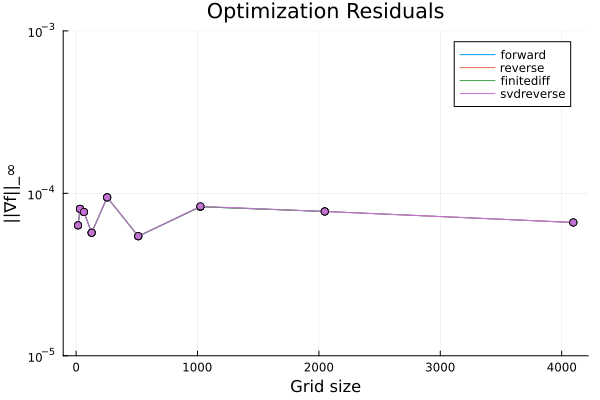

In [9]:
ad_df = DataFrames.groupby(res_df, :AD)
p = plot(;
    legend=true,
    title="Optimization Residuals",
    ylabel="||∇f||_∞",
    xlabel="Grid size",
    yscale=:log10,
    ylim=(10^-5, 10^-3),
    # xscale=:log10,
    # xticks=grid_sizes
)
for (k,df) in enumerate(ad_df)
    # println(df)
    method = df[1,:AD]
    grid_sizes = df[:,:GridSize]
    residuals = df[:,:Residual]
    plot!(p, grid_sizes, residuals, color=k, label=string(method))
    scatter!(p, grid_sizes, residuals, color=k, label=nothing)
end
display(p)

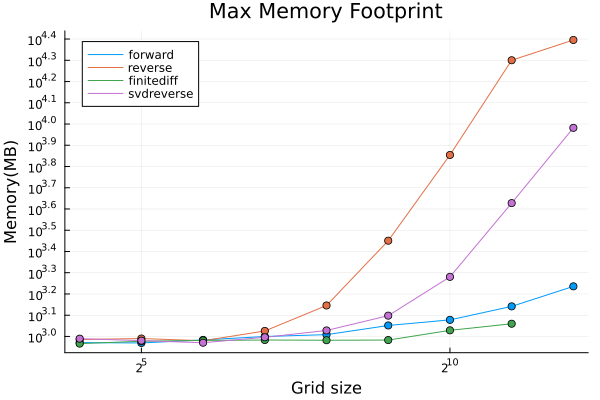

In [10]:
ad_df = DataFrames.groupby(res_df, :AD)
p = plot(;
    legend=true,
    title="Max Memory Footprint",
    ylabel="Memory(MB)",
    xlabel="Grid size",
    yscale=:log10,
    yticks=10.0 .^ (2.8:0.1:5.0),
    xscale=:log2,
)
for (k,df) in enumerate(ad_df)
    # println(df)
    method = df[1,:AD]
    grid_sizes = df[:,:GridSize]
    mem_res = df[:,:MaxRSS]
    plot!(p, grid_sizes, mem_res, color=k, label=string(method))
    scatter!(p, grid_sizes, mem_res, color=k, label=nothing)
end
display(p)

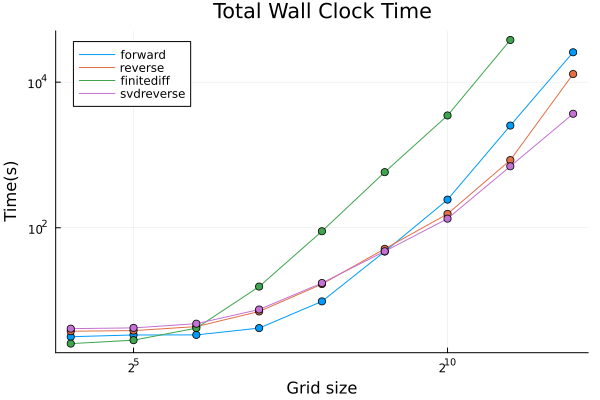

In [11]:
ad_df = DataFrames.groupby(res_df, :AD)
p = plot(;
    legend=:topleft,
    title="Total Wall Clock Time",
    ylabel="Time(s)",
    xlabel="Grid size",
    yscale=:log10,
    xscale=:log2,
    # xticks=grid_sizes
)
for (k,df) in enumerate(ad_df)
    # println(df)
    method = df[1,:AD]
    grid_sizes = df[:,:GridSize]
    times = df[:,:Time]
    plot!(p, grid_sizes, times, color=k, label=string(method))
    scatter!(p, grid_sizes, times, color=k, label=nothing)
end
display(p)

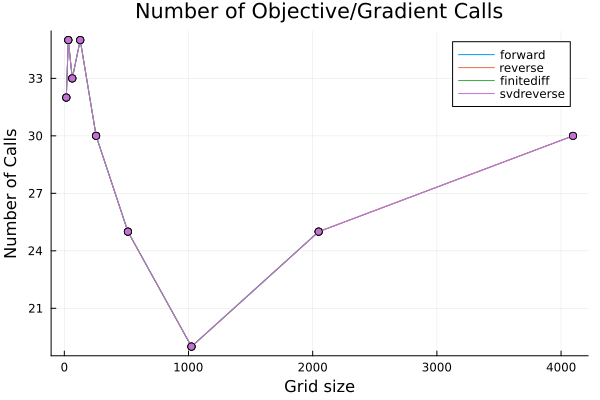

In [12]:
ad_df = DataFrames.groupby(res_df, :AD)
p = plot(;
    legend=true,
    title="Number of Objective/Gradient Calls",
    ylabel="Number of Calls",
    xlabel="Grid size",
    # yscale=:log10,
    # xscale=:log10,
    # xticks=grid_sizes
)
for (k,df) in enumerate(ad_df)
    # println(df)
    method = df[1,:AD]
    grid_sizes = df[:,:GridSize]
    ncalls = df[:,:NumCalls]
    plot!(p, grid_sizes, ncalls, color=k, label=string(method))
    scatter!(p, grid_sizes, ncalls, color=k, label=nothing)
end
display(p)

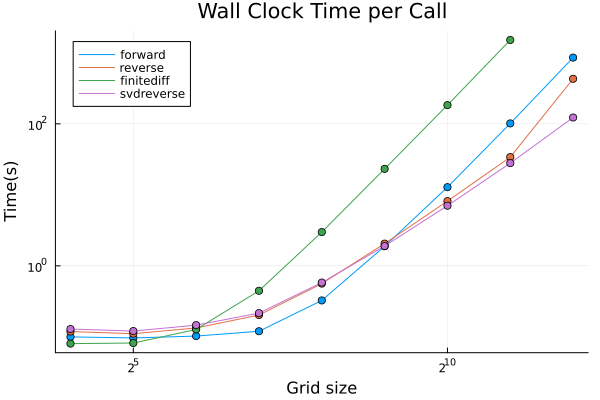

In [13]:
ad_df = DataFrames.groupby(res_df, :AD)
p = plot(;
    legend=:topleft,
    title="Wall Clock Time per Call",
    ylabel="Time(s)",
    xlabel="Grid size",
    yscale=:log10,
    xscale=:log2,
    # xticks=grid_sizes
)
for (k,df) in enumerate(ad_df)
    # println(df)
    method = df[1,:AD]
    grid_sizes = df[:,:GridSize]
    times = df[:,:Time] ./ df[:,:NumCalls]
    plot!(p, grid_sizes, times, color=k, label=string(method))
    scatter!(p, grid_sizes, times, color=k, label=nothing)
end
display(p)

# Memory Usage

In [14]:
function svd_dimensions(ngrid)
    k = log2(ngrid)
    m = 2^Int(ceil(k/2))
    n = 2^Int(floor(k/2))
    return (m,n)
end

function svd_mem(nsv, ngrid)
    # m = Int(sqrt(ngrid))
    # return nsv + 2*nsv*m
    (m,n) = svd_dimensions(ngrid)
    return nsv * (m + n + 1)
end

function svd_mem_sweep(ngrid)
    # m = Int(sqrt(ngrid))
    (m,n) = svd_dimensions(ngrid)
    nsvs = 1:min(m,n)
    mem_svd = zeros(Int, min(m,n))
    for nsv in nsvs
        mem_svd[nsv] = svd_mem(nsv, ngrid)
    end
    return (nsvs, mem_svd)
end

function svd_mem_savings()
    mem_savings = Dict{Int, Any}()
    for k in 2:14
        Nx = 2^k
        (nsvs, mem_svd) = svd_mem_sweep(Nx)
        saving = Nx * 8 / 1024 .- mem_svd * 8 / 1024
        mem_savings[Nx] = (nsvs, saving)
    end
    return mem_savings
end

function plot_savings(mem_save)
    (m,n) = svd_dimensions(maximum(keys(mem_save)))
    xmax = 0.5 * max(m,n)
    p = plot(
        # xscale=:log10,
        legend=true,
        ylabel="kB",
        xlabel="Number Singular Values",
        title="SVD compression vs standard (per step)",
        xlim=(0, xmax),
    )
    for Nx in sort(collect(keys(mem_save)))
        (nsvs, save) = mem_save[Nx]
        plot!(p, nsvs, save, label=string(Nx))
    end
    return p
end

plot_savings (generic function with 1 method)

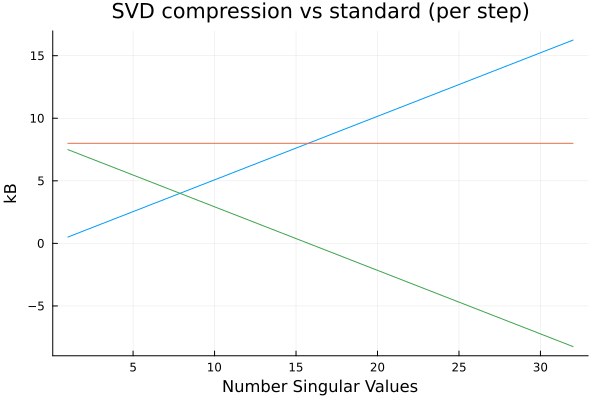

In [15]:
Nx = 1024
(num_svs, mem_svd) = svd_mem_sweep(Nx)
p = plot(num_svs, mem_svd * 8 / 1024,
    legend=false,
    ylabel="kB",
    xlabel="Number Singular Values",
    title="SVD compression vs standard (per step)",
)
plot!(p, num_svs, fill(Nx * 8 / 1024, length(num_svs)))
plot!(p, num_svs, fill(Nx * 8 / 1024, length(num_svs)) - mem_svd * 8 / 1024, label="Savings")

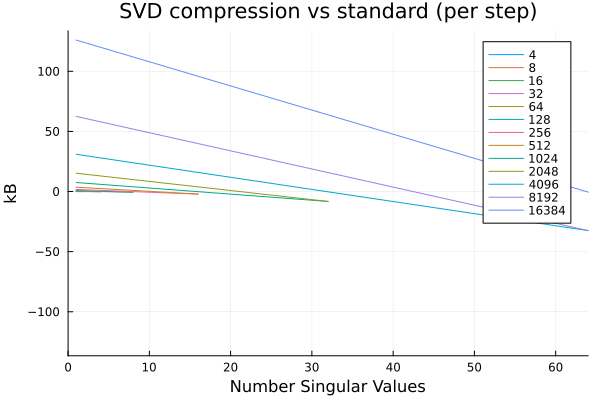

In [16]:
mr = svd_mem_savings()
plot_savings(mr)

# SVD Effects on Solution

In [17]:
import BurgersEquation
import ImplicitAD as IAD

In [18]:
function grid_control(i, xi, x, p)
    return x[i]
end

function tf_sin(x)
    return 0.5 + 0.2 * sin(2 * pi * x)
end
    
function initial_condition(x, p)

    Nx = p[:Nx]
    ic = p[:ic]
    u0 = zeros(eltype(x), Nx)

    for i in 1:Nx
        xi = BurgersEquation.gridpoint(i, Nx)
        u0[i] = ic(i, xi, x, p)
    end

    return u0

end

function burger_solution(
    x,
    p;
    save::Bool=false,
    progress::Bool=false,
)

    f(u) = 0.5 * u^2
    fu(u) = u

    u0 = initial_condition(x, p)
    Nx = p[:Nx]
    cfl = p[:cfl]
    tf = p[:tf]
    # Assumes u >= 0
    umax = maximum(u0)
    dx = BurgersEquation.gridsize(Nx)
    dt = 1.0 / ceil(tf * umax / (cfl * dx))

    save_rate = save ? max(1, Int(floor(2e-3 / dt))) : -1
    cfl = dt * umax / dx

    bp = BurgersEquation.setup(
        u0, f, fu, p[:tf], dt, Nx, p[:flux];
        save_rate=save_rate
    )
    BurgersEquation.solve(bp; progress=progress)

    return bp

end

burger_solution (generic function with 1 method)

In [19]:
Nx = 2^12
cfl = 0.85
tf = 1.0
dx = BurgersEquation.gridsize(Nx)
my_params = Dict(
    :Nx => Nx,
    :cfl => cfl,
    :tf => tf,
    :flux => :lf,
    :scale => 1e2,
    :ic => grid_control,
    # :target => tf_sin,
    :mode => :normal,
)
# x0 = fill(0.2, Nx)
# x0 = [tf_sin(xk) for xk in 0.0:dx:1.0-0.5*dx]
u0csv = joinpath(results_dir, make_base_name(:reverse, Nx) * ".csv")
df = CSV.read(u0csv, DataFrames.DataFrame, header=false)
x0 = df[:,:Column1]
# (m, n) = svd_dimensions(Nx)
bp = burger_solution(x0, my_params; progress=true)
(m,n) = svd_dimensions(Nx)
@show Nx
@show svd_dimensions(Nx)
;

Progress: 100%|█████████████████████████████████████████████████████████████| Time: 0:00:01


Nx = 4096
svd_dimensions(Nx) = (64, 64)


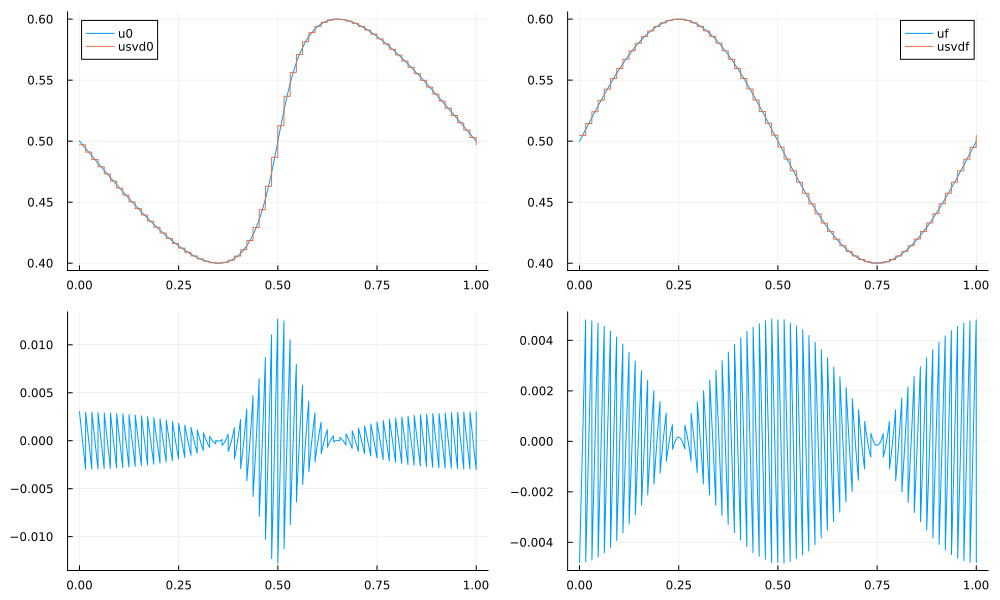

In [20]:
u0 = bp.u0
uf = bp.uk
usvd0 = IAD.SVDVector(u0, m, n, 1)
usvdf = IAD.SVDVector(uf, m, n, 1)
p1 = plot(BurgersEquation.space_grid(Nx), BurgersEquation.expand_solution(u0), label="u0")
plot!(p1, BurgersEquation.space_grid(Nx), BurgersEquation.expand_solution(usvd0), label="usvd0")
q1 = plot(BurgersEquation.space_grid(Nx), BurgersEquation.expand_solution(u0 - usvd0), label=nothing)
# display(p)
p2 = plot(BurgersEquation.space_grid(Nx), BurgersEquation.expand_solution(uf), label="uf")
plot!(p2, BurgersEquation.space_grid(Nx), BurgersEquation.expand_solution(usvdf), label="usvdf")
q2 = plot(BurgersEquation.space_grid(Nx), BurgersEquation.expand_solution(uf - usvdf), label=nothing)
p = plot(p1, p2, q1, q2, size=(1000,600))
# png(p, "/Users/jmaack/Desktop/SVDcompression")
# display(p)

usvd0.nsv = 5
usvdf.nsv = 4


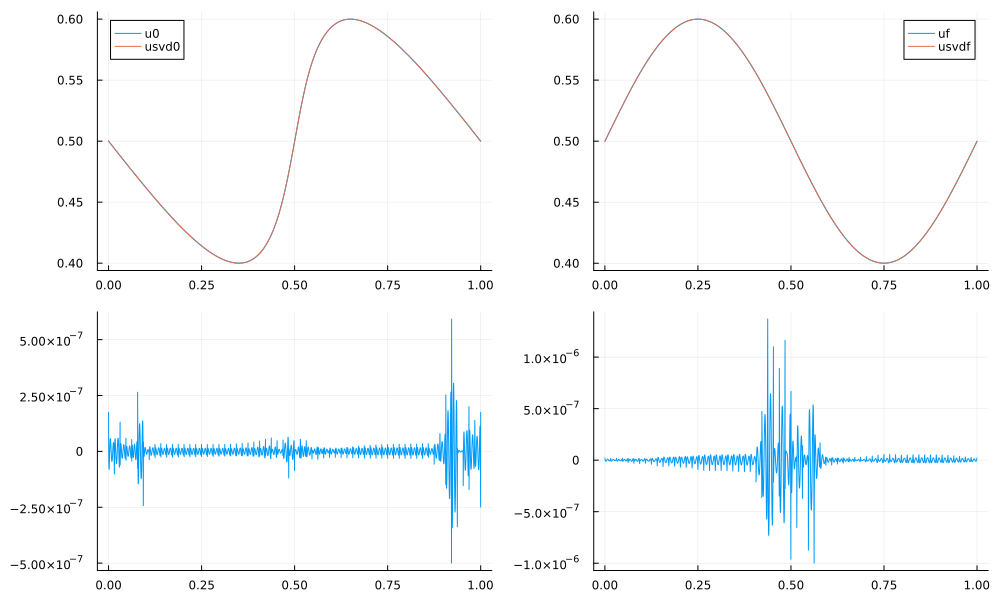

In [21]:
u0 = bp.u0
uf = bp.uk
usvd0 = IAD.SVDVector(u0, m, n, 1e-5)
@show usvd0.nsv
usvdf = IAD.SVDVector(uf, m, n, 1e-5)
@show usvdf.nsv
p1 = plot(BurgersEquation.space_grid(Nx), BurgersEquation.expand_solution(u0), label="u0")
plot!(p1, BurgersEquation.space_grid(Nx), BurgersEquation.expand_solution(usvd0), label="usvd0")
q1 = plot(BurgersEquation.space_grid(Nx), BurgersEquation.expand_solution(u0 - usvd0), label=nothing)
# display(p)
p2 = plot(BurgersEquation.space_grid(Nx), BurgersEquation.expand_solution(uf), label="uf")
plot!(p2, BurgersEquation.space_grid(Nx), BurgersEquation.expand_solution(usvdf), label="usvdf")
q2 = plot(BurgersEquation.space_grid(Nx), BurgersEquation.expand_solution(uf - usvdf), label=nothing)
plot(p1, p2, q1, q2, size=(1000,600))
# display(p)